In [1]:
import pandas as pd
import numpy as np

from sklearn import pipeline
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.feature_extraction as fe
import sklearn.preprocessing as pp
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from matplotlib import pyplot as plt

%matplotlib inline

In [42]:
# that was a fun exercise but ultimately fruitless in the face of pd.DataFrame weirdness with string vars

# def conditional_freq_count(str_list):
#     l = len(str_list)
#     freqs = [str_list.count(i) for i in str_list]
#     freqs = [i / l for i in freqs]
#     return(freqs)

# ls = ['a', 'a', 'b', 'b', 'c', 'c', 'd', 'd', 'e', 'f']
# conditional_freq_count(ls)

In [1]:
# !ls ../data

Icon?                pydat.csv            pytrain.csv
merged-dataset.RData pytest.csv           raw-data.RData


In [2]:
dat = pd.read_csv('../OMAD_adverse_outcome_mod/data/ALL-STU-transformed-data-to-py.csv')
dat.columns
dat.dropna(subset = ['Y'], inplace = True)

In [3]:
dat['tran_major_abbr'].fillna(value = 'None', inplace = True)

In [4]:
mjr_orig_counts = dat['tran_major_abbr'].value_counts() / dat.shape[0]
mjr_orig_counts[1:10]

PRESCI    0.048787
PREMAJ    0.037030
BIOL      0.023365
PRENGR    0.021796
B PRE     0.020175
PSOCS     0.018255
MED       0.017888
PSYCH     0.017259
E E       0.015570
Name: tran_major_abbr, dtype: float64

<AxesSubplot:title={'center':'Y'}, xlabel='hs_math_level'>

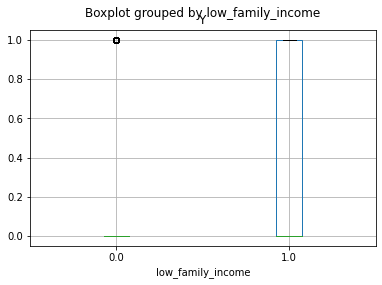

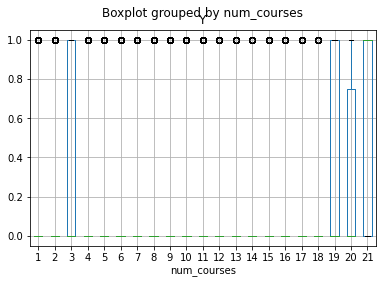

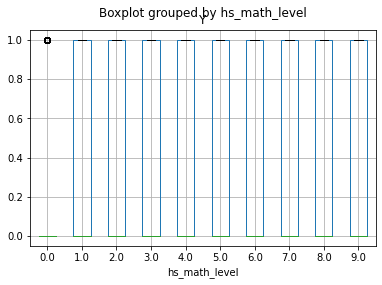

In [5]:
dat.boxplot('Y', 'low_family_income')
dat.boxplot('Y', 'num_courses')
dat.boxplot('Y', 'hs_math_level')

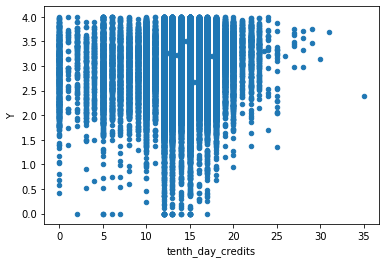

In [12]:
dat.plot.scatter('tenth_day_credits', 'Y')

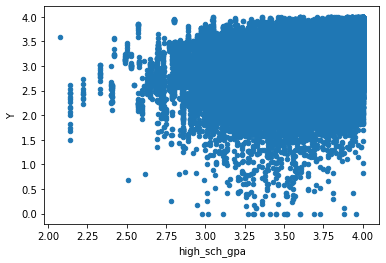

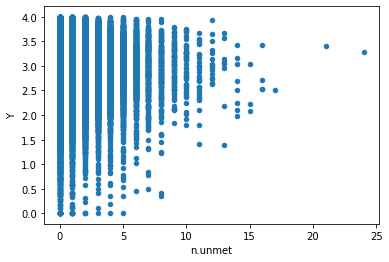

In [180]:
dat.plot.scatter('high_sch_gpa', 'Y')
dat.plot.scatter('n.unmet', 'Y')

In [13]:
# one option: hash major strings
fh = fe.FeatureHasher(n_features = 30, input_type = 'string')
mjr_hash = fh.transform(dat['tran_major_abbr'])
mjr_hash.toarray()

array([[ 0., -1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.]])

In [15]:
mjr_hash.get_shape()

(138836, 30)

In [48]:
x = np.array(['a', 'a', 'b', 'c', 'd', 'd', 'd', 'b', 'd'])
n_uniq = len(np.unique(x))
freq = [list(x).count(i) for i in x]
weight = []

In [50]:
print(x)
print(n_uniq)
print(freq)
print(weight)

['a' 'a' 'b' 'c' 'd' 'd' 'd' 'b' 'd']
4
[2, 2, 2, 1, 4, 4, 4, 2, 4]


In [8]:
# conditional_freq_count(dat['tran_major_abbr'])
# len(dat['tran_major_abbr'])

dat['mjr_freq'] = dat.groupby(dat['tran_major_abbr'])['tran_major_abbr'].transform('size')
dat['mjr_freq'] = dat['mjr_freq'] / len(dat['mjr_freq'])
dat['mjr_freq'].head(20)

0     0.008017
1     0.008017
2     0.008017
3     0.008017
4     0.008017
5     0.008017
7     0.053329
8     0.053329
9     0.053329
11    0.010192
12    0.010192
13    0.010192
14    0.010674
15    0.010674
16    0.010674
17    0.010674
19    0.001505
20    0.001505
22    0.006562
23    0.006562
Name: mjr_freq, dtype: float64

In [ ]:
# y = dat['Y'].values

In [76]:
def zscore(x):
    return((x - x.mean()) / x.std())

sat = dat['s1_high_satm'] + dat['s1_high_satv']
act = dat['s1_high_act']

dat['pmax_test_score'] = np.fmax(zscore(sat), zscore(act))

In [85]:
xmat = dat.drop(['Unnamed: 0', 'system_key', 'tran_major_abbr',
                's1_high_satm', 's1_high_satv', 's1_high_act'], axis = 1)
xmat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138836 entries, 0 to 156968
Data columns (total 52 columns):
Y                                138836 non-null float64
qtr.num                          138836 non-null int64
class                            138836 non-null int64
tenth_day_credits                138836 non-null float64
scholarship_type                 138836 non-null int64
num_courses                      138836 non-null int64
pts                              138836 non-null float64
attmp                            138836 non-null float64
nongrd                           138836 non-null float64
deduct                           138836 non-null int64
qgpa                             135999 non-null float64
tot_creds                        138836 non-null float64
cum.pts                          138836 non-null float64
cum.attmp                        138836 non-null float64
s1_gender                        138762 non-null object
child_of_alum                    138836 non-n

In [86]:
# any additional drops w/ lots of NAs?
# xmat.drop(columns = 'trans_gpa', inplace = True)

# let's take pmax of transfer or highschool gpa
xmat['pmax_gpa'] = np.fmax(xmat['trans_gpa'], xmat['high_sch_gpa'])

In [87]:
xmat.drop(columns = ['trans_gpa', 'high_sch_gpa'], inplace = True)

### Handling categorical features

In [88]:
xmat.replace(('Y', 'N'), (1, 0), inplace = True)
xmat['s1_gender'].replace(('F', 'M'), (1,0), inplace = True)

In [89]:
xmat['ResidentDesc'].unique()
# one-hot encode this one
xmat = pd.get_dummies(xmat, columns = ['ResidentDesc'], prefix = ['resident_desc'])

### Train/test setup (skl)

In [98]:
xmat_drop_na = xmat.copy()
xmat_drop_na.dropna(axis = 1, inplace = True)
y = xmat_drop_na['Y'].values
xmat_drop_na.drop(columns = ['Y'], inplace = True)

In [99]:
train_x, test_x, train_y, test_y = train_test_split(xmat_drop_na, y, train_size = .7)

### OLS

In [88]:
linear_model.LinearRegression?

In [101]:
ols = linear_model.LinearRegression(n_jobs = -1)
ols.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [110]:
ols.score(test_x, test_y)

0.7391234258077211

### Ridge

In [113]:
ridge_reg = linear_model.RidgeCV(alphas = np.logspace(-5, 5, 11), cv = 5)
ridge_reg.fit(train_x, train_y)


RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [117]:
ridge_reg.score(test_x, test_y)

0.7407229576160866

### SGD

In [131]:
# sgd = SGDRegressor(penalty = 'l2', max_iter = 10000, warm_start = True)
# sgd.fit(train_x, train_y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=10000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=True)

In [132]:
# sgd.score(test_x, test_y)

-2.64019643842905e+24

### RF

In [144]:
rfc = RandomForestRegressor(n_estimators = 600, max_depth = 5, min_samples_split = 4,
                           n_jobs = -1)
# rfc_scores = cross_val_score(rfc, train_x, train_y, cv = 5)
rfc.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [145]:
rfc.score(test_x, test_y)

0.567049883478626

In [147]:
rfc.feature_importances_

array([4.57173092e-04, 1.92366651e-06, 6.45649252e-05, 3.33434486e-01,
       8.60655621e-05, 4.91071074e-01, 1.47082328e-01, 6.49097624e-05,
       5.31955095e-03, 7.37979787e-06, 8.81117318e-03, 1.70283159e-03,
       2.59705735e-05, 5.02285011e-07, 1.09353244e-05, 5.31394372e-07,
       1.89243546e-05, 1.15094261e-06, 6.57246340e-07, 8.74200788e-07,
       1.77174698e-06, 7.83832397e-05, 1.98526522e-06, 1.21960082e-06,
       7.70457207e-06, 1.16674184e-02, 1.26897293e-05, 1.90796901e-05,
       4.42496507e-05, 6.94293030e-07, 0.00000000e+00, 0.00000000e+00,
       1.24915114e-06, 5.48078043e-07])

### Plot multiple outputs

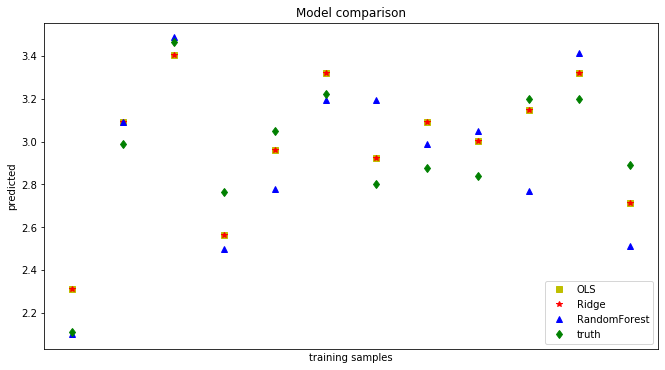

In [162]:
xt = train_x[:12]
yt = train_y[:12]

plt.figure(figsize = (11, 6))
plt.plot(ols.predict(xt), 'ys', label = 'OLS')
plt.plot(ridge_reg.predict(xt), 'r*', label = 'Ridge')
# plt.plot(sgd.predict(xt), 'gd', label = 'SGD')
plt.plot(rfc.predict(xt), 'b^', label = 'RandomForest')
plt.plot(yt, 'gd', label = 'truth')

plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc = 'best')
plt.title('Model comparison')
plt.show()